In [1]:
%load_ext autoreload
%autoreload 2

from imp import reload
import os, time
import numpy as np
import pickle
from helpers import comp_evs
import matplotlib.pyplot as plt

# RNN model and task
import torch
use_cuda = torch.cuda.is_available()
from model import RNN, train, run_net
from task_generators import input_driven_fp
task_generator = input_driven_fp

# Data directory for saving
from data_dir import data_dir



# Name
file_name_prefix = "linear" 
torch.cuda.set_device("cuda:3")

In [2]:
# Optimizer
optimizer = 'sgd'

# Nonlinearity
nonlinearity = 'id'
##nonlinearity = 'tanh'

# Integration time step
dt = 0.5
# Training parameters
batch_size = 1
batch_size_test = 1
# Neural noise
noise_std = 0.0
# Whether IO vectors are orthogonalized
orthogonalize_wio = False
# Same random connectivity for each g?
same_connectivity = False

# Number of epochs
n_epochs = 200
# Record the weights only every 'rec_step'
rec_step = 1

# Network parameters
dim_in = 1
dim_out = dim_in

In [3]:
scenario = ['fig_3_4', 'supp_fig_diverge', 'test'][0]

if scenario == 'fig_3_4':
    # Fig 3,4
    dim_rec = 1024

    # Train for different randomness
    dg = 0.1
    gs = np.arange(0, 1, dg)

    # Number of samples
    n_samples = 5

    # Task
    # Target amplitudes
    target_amps = np.array([0.5, 1.0, 2.0])
    # Trail time
    t_max = 101
    # Learning rates for g == 0
    lr0s = np.array([0.015, 0.009, 0.003])

    compute_evs = False

elif scenario == 'supp_fig_diverge':
    # Diverging learning for supplementary
    dim_rec = 256

    # Initial connectivity strength
    gs = np.array([0.6, 0.8])

    # Number of samples
    n_samples = 5

    # Target amplitudes
    # target_amps = np.array([1., 2., 3., 4.])
    target_amps = np.array([2., 4.])
    # Trail time
    t_max = 201
    # Learning rates for g == 0
    # lr0s = np.array([0.009, 0.003, 0.002, 0.001])
    lr0s = np.array([0.002, 0.001])

    compute_evs = True
    file_name_prefix += "_diverge"

elif scenario == 'test':
    # Quick testing
    n_samples = 1
    dim_rec = 256
    n_epochs = 20
    t_max = 21
    gs = np.array([0.0, 0.6])
    target_amps = np.array([0.5, 2.])
    lr0s = np.array([0.01, 0.005])
    file_name_prefix = "test_" + file_name_prefix
    compute_evs = False

In [4]:
# Network dimensions
dims = [dim_in, dim_rec, dim_out]

# All task parameters
task_params_all = [{"t_max": t_max, 
                    "fixation_duration": 1,
                    "decision_duration": 1,
                    "input_amp": 1,
                    "target_amp": target_amp,}
                   for target_amp in target_amps]

# Learning rates
lrs_all = lr0s[:, None] * (1 - gs[None, :]**2)**2

# Epochs
n_rec_epochs = n_epochs // rec_step
epochs = np.arange(n_epochs)
rec_epochs = np.arange(0, n_epochs, rec_step)
# Learning times
tls_all = lrs_all[:, :, None] * epochs[None, None, :]

# Results arrays
n_gs = len(gs)
n_tas = len(target_amps)
# Weights
wi_init_all = np.zeros((n_samples, n_tas, n_gs, dim_in, dim_rec))
wo_init_all = np.zeros((n_samples, n_tas, n_gs, dim_rec, dim_out))
wrec_init_all = np.zeros((n_samples, n_tas, n_gs, dim_rec, dim_rec))
dwrec_last_all = np.zeros((n_samples, n_tas, n_gs, dim_rec, dim_rec))
# Results
losses_all = np.zeros((n_samples, n_tas, n_gs, n_epochs))
grad_norms_all = np.zeros((n_samples, n_tas, n_gs, n_epochs))
ev_w_all = np.zeros((n_samples, n_tas, n_gs, n_epochs, dim_rec), dtype=complex)
sv_dw_all = np.zeros((n_samples, n_tas, n_gs, n_rec_epochs, dim_rec))
loss_shuff_all = np.zeros((n_samples, n_tas, n_gs))

# File name
file_name = file_name_prefix
if n_tas == 1:
    target_amp = target_amps[0]
    file_name += "_zhat_%.1f"%target_amp
else:
    file_name += "_zhats"
if n_gs == 1:
    g = gs[0]
    file_name += "_g_%.1f" % g
else:
    file_name += "_gs"
if optimizer != 'sgd':
    file_name += '_' + optimizer
if same_connectivity:
    file_name += "_same_conn"
if orthogonalize_wio:
    file_name += "_ortho_wio"
if noise_std != 0:
    file_name += "_noise_%.1f"%noise_std
# Network parameters
file_name += "_N_%d" % dim_rec
file_name += "_tmax_%d" % t_max
file_name = "".join(file_name.split('.'))
print("file_name:\n", file_name)

# Data file for saving
file_name  = file_name + "_fwdmodeV1"
data_file_name = file_name + ".pkl"
data_file = os.path.join(data_dir, data_file_name)
print("data_file:\n", data_file)


file_name:
 linear_zhats_gs_N_1024_tmax_101
data_file:
 ../data/linear_zhats_gs_N_1024_tmax_101_fwdmodeV1.pkl


In [12]:
def run(mage= True, fwd_mode = True, n_directions_list = 1, lr_factors = 1, task = 0, warmup = -1, save_V_steps_list = [-1], step_weight = None):
    time_t = 0
    time_ev = 0
    time_sv = 0
    time_ls = 0
    all_results = {}
    j = task
    task_params = task_params_all[j]
    task = task_generator(dims, dt, **task_params)
    i = n_gs//2
    g = gs[i]
    
    
    if not isinstance(lr_factors, list):
        lr_factors = [lr_factors]
        
    
    if not isinstance(n_directions_list, list):
        n_directions_list = [n_directions_list]
        
    for save_V_steps in save_V_steps_list:
        for n_directions in n_directions_list:
            for lr_factor in lr_factors:
                try:
                    lr = lrs_all[j, i]*lr_factor
                    if (not same_connectivity) or (i == 0 and j == 0):
                        # Initial connectivity
                        # Random component
                        wrec_0 = np.random.normal(0, 1 / np.sqrt(dim_rec), (dim_rec, dim_rec))
                        # Input and readout
                        wio = np.random.normal(0, 1, (dim_rec, dim_in + dim_out))
                        if orthogonalize_wio:
                            wio = np.linalg.qr(wio)[0]
                        else:
                            wio /= np.linalg.norm(wio, axis=0)[None, :]
                        # Make sure that the vecotrs are still normalized
                        assert np.allclose(np.linalg.norm(wio, axis=0), 1), "Normalization gone wrong!"
                        # Change normalization to the proper one
                        wio *= np.sqrt(dim_rec)
                        wi_init = wio[:, :dim_in].T.copy()
                        wo_init = wio[:, dim_in:].copy() / dim_rec
                        del wio

                    wrec_init = g * wrec_0

                    # Network
                    net = RNN(dims, noise_std, dt, nonlinearity, g=g, wi_init=wi_init, wo_init=wo_init, wrec_init=wrec_init,
                              train_wi = True, train_wo = True, train_brec = True, train_h0 = True)
                    # Train
                    time0_t = time.time()

                    res = train(net, task, n_epochs, batch_size, lr, cuda=use_cuda, rec_step=rec_step, optimizer=optimizer, 
                                verbose=False, fwd_mode = fwd_mode, mage = mage, n_directions = n_directions,warmup = warmup, save_V_steps = save_V_steps, step_weight = step_weight)
                    losses, grad_norms, weights_init, weights_last, weights_train, _, _ = res
                    # Weights
                    all_results[(save_V_steps,n_directions,lr_factor)] = res
                    plt.semilogy(losses, label = f"lr = {lr_factor}, directions = {n_directions}, SaveV = {save_V_steps}")

                    if mage:
                        print(f"fwd mage, n_directions= {n_directions}, lr = {lr}, SaveV = {save_V_steps}")
                    elif fwd_mode:
                        print(f"fwd mode, n_directions= {n_directions}, lr = {lr}, SaveV = {save_V_steps}")
                    else:
                        print(f"backprop, lr = {lr}")
                except:
                    pass
    plt.legend()
    plt.show()
    return all_results

In [9]:
def run(mage= True, fwd_mode = True, n_directions_list = 1, lr_factors = 1, task = 0, warmup = -1, save_V_steps_list = [-1], step_weight = None):
    time_t = 0
    time_ev = 0
    time_sv = 0
    time_ls = 0
    all_results = {}
    j = task
    task_params = task_params_all[j]
    task = task_generator(dims, dt, **task_params)
    i = n_gs//2
    g = gs[i]
    
    
    if not isinstance(lr_factors, list):
        lr_factors = [lr_factors]
        
    
    if not isinstance(n_directions_list, list):
        n_directions_list = [n_directions_list]
        
    for save_V_steps in save_V_steps_list:
        for n_directions in n_directions_list:
            for lr_factor in lr_factors:
                if True:
                    lr = lrs_all[j, i]*lr_factor
                    if (not same_connectivity) or (i == 0 and j == 0):
                        # Initial connectivity
                        # Random component
                        wrec_0 = np.random.normal(0, 1 / np.sqrt(dim_rec), (dim_rec, dim_rec))
                        # Input and readout
                        wio = np.random.normal(0, 1, (dim_rec, dim_in + dim_out))
                        if orthogonalize_wio:
                            wio = np.linalg.qr(wio)[0]
                        else:
                            wio /= np.linalg.norm(wio, axis=0)[None, :]
                        # Make sure that the vecotrs are still normalized
                        assert np.allclose(np.linalg.norm(wio, axis=0), 1), "Normalization gone wrong!"
                        # Change normalization to the proper one
                        wio *= np.sqrt(dim_rec)
                        wi_init = wio[:, :dim_in].T.copy()
                        wo_init = wio[:, dim_in:].copy() / dim_rec
                        del wio

                    wrec_init = g * wrec_0

                    # Network
                    net = RNN(dims, noise_std, dt, nonlinearity, g=g, wi_init=wi_init, wo_init=wo_init, wrec_init=wrec_init,
                              train_wi = True, train_wo = True, train_brec = True, train_h0 = True)
                    # Train
                    time0_t = time.time()

                    res = train(net, task, n_epochs, batch_size, lr, cuda=use_cuda, rec_step=rec_step, optimizer=optimizer, 
                                verbose=False, fwd_mode = fwd_mode, mage = mage, n_directions = n_directions,warmup = warmup, save_V_steps = save_V_steps, step_weight = step_weight)
                    losses, grad_norms, weights_init, weights_last, weights_train, _, _ = res
                    # Weights
                    all_results[(save_V_steps,n_directions,lr_factor)] = res
                    plt.semilogy(losses, label = f"lr = {lr_factor}, directions = {n_directions}, SaveV = {save_V_steps}")

                    if mage:
                        print(f"fwd mage, n_directions= {n_directions}, lr = {lr}, SaveV = {save_V_steps}")
                    elif fwd_mode:
                        print(f"fwd mode, n_directions= {n_directions}, lr = {lr}, SaveV = {save_V_steps}")
                    else:
                        print(f"backprop, lr = {lr}")

    plt.legend()
    plt.show()
    return all_results

In [ ]:
%time all_results = run(mage = True, fwd_mode = True, n_directions_list = [1], lr_factors = [3,1,0.3,0.1,0.03,0.01] ,warmup = 3, save_V_steps_list = [-1,200,100,50,20,10,5,1])


step_weight

loss: 1.28e-01:   0%|▋                                                                                                                                             | 1/200 [00:00<00:21,  9.40it/s]

fwd mage, n_directions= 1, lr = 0.0253125, SaveV = -1


loss: 1.30e-01:   0%|▋                                                                                                                                             | 1/200 [00:00<00:21,  9.39it/s]

fwd mage, n_directions= 1, lr = 0.0084375, SaveV = -1


loss: 1.35e-01:   0%|▋                                                                                                                                             | 1/200 [00:00<00:22,  8.77it/s]

fwd mage, n_directions= 1, lr = 0.00253125, SaveV = -1


loss: 1.26e-01:   0%|▋                                                                                                                                             | 1/200 [00:00<00:21,  9.39it/s]

fwd mage, n_directions= 1, lr = 0.0008437500000000001, SaveV = -1


loss: 1.39e-01:   0%|▋                                                                                                                                             | 1/200 [00:00<00:21,  9.41it/s]

fwd mage, n_directions= 1, lr = 0.000253125, SaveV = -1


loss: 1.20e-01:   0%|▋                                                                                                                                             | 1/200 [00:00<00:20,  9.86it/s]

fwd mage, n_directions= 1, lr = 8.4375e-05, SaveV = -1


loss: 1.03e-01:   0%|                                                                                                                                                      | 0/200 [00:00<?, ?it/s]

fwd mage, n_directions= 1, lr = 0.0253125, SaveV = 200


loss: 1.37e-01:   0%|▋                                                                                                                                             | 1/200 [00:00<00:22,  8.97it/s]

fwd mage, n_directions= 1, lr = 0.0084375, SaveV = 200


loss: 1.16e-01:   0%|▋                                                                                                                                             | 1/200 [00:00<00:20,  9.92it/s]

fwd mage, n_directions= 1, lr = 0.00253125, SaveV = 200


loss: 1.30e-01:   0%|▋                                                                                                                                             | 1/200 [00:00<00:20,  9.65it/s]

fwd mage, n_directions= 1, lr = 0.0008437500000000001, SaveV = 200


loss: 1.07e-01:   0%|                                                                                                                                                      | 0/200 [00:00<?, ?it/s]

fwd mage, n_directions= 1, lr = 0.000253125, SaveV = 200


loss: 1.40e-01:   0%|▋                                                                                                                                             | 1/200 [00:00<00:22,  8.84it/s]

fwd mage, n_directions= 1, lr = 8.4375e-05, SaveV = 200


loss: 9.57e-02:   0%|▋                                                                                                                                             | 1/200 [00:00<00:21,  9.25it/s]

fwd mage, n_directions= 1, lr = 0.0008437500000000001, SaveV = 100


loss: 1.33e-01:   0%|▋                                                                                                                                             | 1/200 [00:00<00:25,  7.95it/s]

fwd mage, n_directions= 1, lr = 0.000253125, SaveV = 100


loss: 1.25e-01:   0%|▋                                                                                                                                             | 1/200 [00:00<00:25,  7.94it/s]

fwd mage, n_directions= 1, lr = 8.4375e-05, SaveV = 100


loss: 1.17e-01:   0%|▋                                                                                                                                             | 1/200 [00:00<00:23,  8.31it/s]

fwd mage, n_directions= 1, lr = 0.0008437500000000001, SaveV = 50


loss: 1.46e-01:   0%|▋                                                                                                                                             | 1/200 [00:00<00:24,  8.11it/s]

fwd mage, n_directions= 1, lr = 0.000253125, SaveV = 50


loss: 1.02e-01:   0%|▋                                                                                                                                             | 1/200 [00:00<00:24,  8.27it/s]

fwd mage, n_directions= 1, lr = 8.4375e-05, SaveV = 50


loss: 1.32e-01:   0%|▋                                                                                                                                             | 1/200 [00:00<00:23,  8.49it/s]

fwd mage, n_directions= 1, lr = 0.00253125, SaveV = 20


loss: 9.68e-02:   0%|▋                                                                                                                                             | 1/200 [00:00<00:23,  8.51it/s]

fwd mage, n_directions= 1, lr = 0.0008437500000000001, SaveV = 20


loss: 9.51e-02:   0%|▋                                                                                                                                             | 1/200 [00:00<00:23,  8.56it/s]

fwd mage, n_directions= 1, lr = 0.000253125, SaveV = 20


loss: 1.61e-01:   0%|▋                                                                                                                                             | 1/200 [00:00<00:23,  8.63it/s]

fwd mage, n_directions= 1, lr = 8.4375e-05, SaveV = 20


loss: 1.19e-01:   0%|▋                                                                                                                                             | 1/200 [00:00<00:21,  9.27it/s]

fwd mage, n_directions= 1, lr = 0.00253125, SaveV = 10


  0%|                                                                                                                                                                      | 0/200 [00:00<?, ?it/s]

fwd mage, n_directions= 1, lr = 0.0008437500000000001, SaveV = 10


loss: 1.28e-01:   0%|▋                                                                                                                                             | 1/200 [00:00<00:25,  7.80it/s]

fwd mage, n_directions= 1, lr = 0.000253125, SaveV = 10


loss: 1.24e-01:   0%|▋                                                                                                                                             | 1/200 [00:00<00:21,  9.23it/s]

fwd mage, n_directions= 1, lr = 8.4375e-05, SaveV = 10


  0%|                                                                                                                                                                      | 0/200 [00:00<?, ?it/s]

fwd mage, n_directions= 1, lr = 0.0084375, SaveV = 5


loss: 0.00e+00: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:42<00:00,  4.72it/s]


fwd mage, n_directions= 1, lr = 0.00253125, SaveV = 5


loss: 4.55e-13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.11it/s]


fwd mage, n_directions= 1, lr = 0.0008437500000000001, SaveV = 5


loss: 6.10e-07: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.21it/s]


fwd mage, n_directions= 1, lr = 0.000253125, SaveV = 5


loss: 1.19e-01:   0%|▋                                                                                                                                             | 1/200 [00:00<00:21,  9.33it/s]

fwd mage, n_directions= 1, lr = 8.4375e-05, SaveV = 5


loss: 0.00e+00: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:00<00:00,  3.28it/s]


fwd mage, n_directions= 1, lr = 0.0253125, SaveV = 1


loss: 1.40e-01:   0%|▋                                                                                                                                             | 1/200 [00:00<00:25,  7.95it/s]

fwd mage, n_directions= 1, lr = 0.0084375, SaveV = 1


loss: 1.01e-01:   0%|▋                                                                                                                                             | 1/200 [00:00<00:24,  7.99it/s]

fwd mage, n_directions= 1, lr = 0.00253125, SaveV = 1


loss: 2.23e-08: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:01<00:00,  3.24it/s]


fwd mage, n_directions= 1, lr = 0.0008437500000000001, SaveV = 1


  0%|                                                                                                                                                                      | 0/200 [00:00<?, ?it/s]

fwd mage, n_directions= 1, lr = 0.000253125, SaveV = 1


loss: 1.18e-06: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:47<00:00,  4.21it/s]


fwd mage, n_directions= 1, lr = 8.4375e-05, SaveV = 1


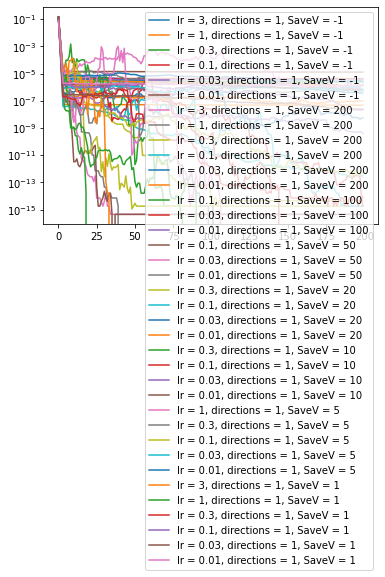

CPU times: user 24min 38s, sys: 1min 23s, total: 26min 2s
Wall time: 22min 32s


In [13]:
%time all_results = run(mage = True, fwd_mode = True, n_directions_list = [1], lr_factors = [3,1,0.3,0.1,0.03,0.01] ,warmup = 3, save_V_steps_list = [-1,200,100,50,20,10,5,1], step_weight = "linear")


In [24]:
all_results = _

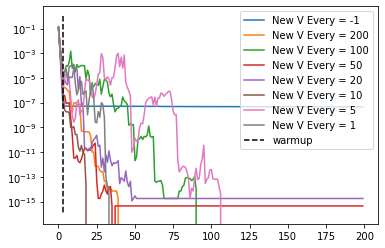

In [14]:


for save_V_steps in [-1,200,100,50,20,10,5,1]:
    for n_directions in [1]:
        minimal = 10000000
        best = -1
        for lr_factor in [3,1,0.3,0.1,0.03,0.01]:
            try:
                losses = all_results[(save_V_steps,n_directions,lr_factor)][0]
                if minimal > losses.min():
                    best = lr_factor
                    minimal = losses.min()
            except:
                pass
        if best >=0:
            losses = all_results[(save_V_steps,n_directions,best)][0]
            plt.semilogy(losses, label = f"New V Every = {save_V_steps}")

plt.plot([3]*100, np.logspace(0,-16,100),"--",color = 'k', label = "warmup")
plt.legend()


In [31]:
list(all_results.keys())

[(-1, 1, 3),
 (-1, 1, 1),
 (-1, 1, 0.3),
 (-1, 1, 0.1),
 (-1, 1, 0.03),
 (-1, 1, 0.01),
 (200, 1, 3),
 (200, 1, 1),
 (200, 1, 0.3),
 (200, 1, 0.1),
 (200, 1, 0.03),
 (200, 1, 0.01),
 (100, 1, 0.3),
 (100, 1, 0.1),
 (100, 1, 0.03),
 (100, 1, 0.01),
 (50, 1, 0.3),
 (50, 1, 0.1),
 (50, 1, 0.03),
 (50, 1, 0.01),
 (20, 1, 0.3),
 (20, 1, 0.1),
 (20, 1, 0.03),
 (20, 1, 0.01),
 (10, 1, 0.3),
 (10, 1, 0.1),
 (10, 1, 0.03),
 (10, 1, 0.01),
 (5, 1, 0.3),
 (5, 1, 0.1),
 (5, 1, 0.03),
 (5, 1, 0.01),
 (1, 1, 3),
 (1, 1, 1),
 (1, 1, 0.3),
 (1, 1, 0.1),
 (1, 1, 0.03),
 (1, 1, 0.01)]

In [21]:
all_results_backup = all_results

NameError: name 'all_results' is not defined

loss: 1.43e-01:   0%|                                                                                                                                                      | 0/200 [00:00<?, ?it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


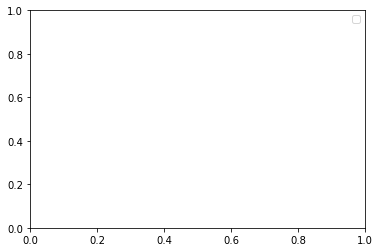

CPU times: user 29.7 s, sys: 708 ms, total: 30.4 s
Wall time: 2.1 s


In [7]:
%time run(mage = True, fwd_mode = True, n_directions_list = [1], lr_factors = [1/10] ,warmup = -1, save_V_steps_list = [-1,200,100,50,20,10,5,1])

loss: 1.53e-01:   0%|                                                                                                                                                      | 0/200 [00:00<?, ?it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


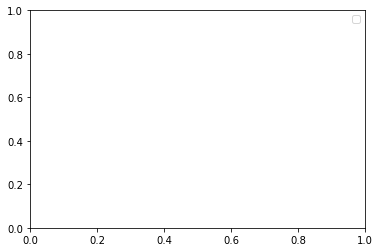

CPU times: user 29.5 s, sys: 830 ms, total: 30.3 s
Wall time: 2.03 s


In [8]:
%time run(mage = True, fwd_mode = True, n_directions_list = [1], lr_factors = [1/10] ,warmup = -1, save_V_steps_list = [-1,200,100,50,20,10,5,1])

loss: 9.81e-02:   0%|                                                                                                                                                      | 0/200 [00:00<?, ?it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


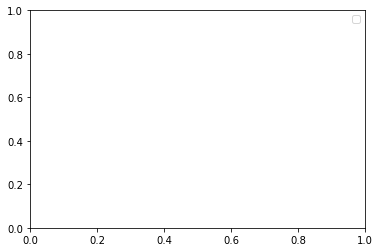

CPU times: user 29.8 s, sys: 725 ms, total: 30.5 s
Wall time: 2.25 s


In [9]:
%time run(mage = True, fwd_mode = True, n_directions_list = [1], lr_factors = [1] ,warmup = -1, save_V_steps_list = [-1,200,100,50,20,10,5,1])

loss: 1.12e-01:   0%|                                                                                                                                                      | 0/200 [00:00<?, ?it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


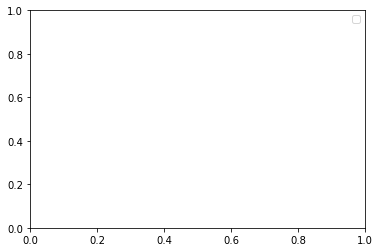

CPU times: user 46.3 s, sys: 1.03 s, total: 47.3 s
Wall time: 4.88 s


In [10]:
%time run(mage = True, fwd_mode = True, n_directions_list = [1,3], lr_factors = [1,2,3,5,7,10])

loss: 1.23e-01:   0%|▋                                                                                                                                             | 1/200 [00:00<00:26,  7.62it/s]

fwd mage, n_directions= 1, lr = 0.0084375, SaveV = -1


loss: 1.46e-01:   0%|▋                                                                                                                                             | 1/200 [00:00<00:26,  7.63it/s]

fwd mage, n_directions= 1, lr = 0.0008437500000000001, SaveV = -1


loss: 8.88e-16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:24<00:00,  8.28it/s]


fwd mage, n_directions= 1, lr = 8.4375e-05, SaveV = -1


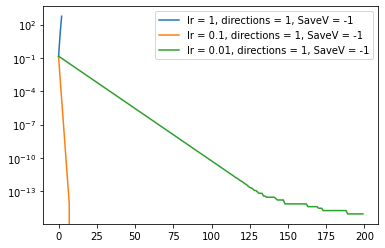

CPU times: user 1min 21s, sys: 3.91 s, total: 1min 25s
Wall time: 1min 13s


In [11]:
%time run(fwd_mode = False, lr_factors = [1,1/10,1/100])

loss: 1.08e-01:   0%|                                                                                                                                                      | 0/200 [00:11<?, ?it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


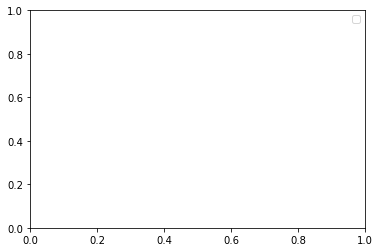

CPU times: user 1min 7s, sys: 2.47 s, total: 1min 9s
Wall time: 37.3 s


In [12]:
%time run(mage = False, fwd_mode = True, n_directions_list = [1,10,100], lr_factors = [1,1/10,1/100])

In [13]:
%%time

print("mage)

time_t = 0
time_ev = 0
time_sv = 0
time_ls = 0
all_results = {}
for k in range(1):    
    for j in range(n_tas):
        task_params = task_params_all[j]
        
        task = task_generator(dims, dt, **task_params)
        
        i = n_gs//2
        g = gs[i]
        lr = lrs_all[j, i]*2
        
        if (not same_connectivity) or (i == 0 and j == 0):
            # Initial connectivity
            # Random component
            wrec_0 = np.random.normal(0, 1 / np.sqrt(dim_rec), (dim_rec, dim_rec))
            # Input and readout
            wio = np.random.normal(0, 1, (dim_rec, dim_in + dim_out))
            if orthogonalize_wio:
                wio = np.linalg.qr(wio)[0]
            else:
                wio /= np.linalg.norm(wio, axis=0)[None, :]
            # Make sure that the vecotrs are still normalized
            assert np.allclose(np.linalg.norm(wio, axis=0), 1), "Normalization gone wrong!"
            # Change normalization to the proper one
            wio *= np.sqrt(dim_rec)
            wi_init = wio[:, :dim_in].T.copy()
            wo_init = wio[:, dim_in:].copy() / dim_rec
            del wio

        wrec_init = g * wrec_0

        # Network
        net = RNN(dims, noise_std, dt, nonlinearity, g=g, wi_init=wi_init, wo_init=wo_init, wrec_init=wrec_init)
        
        # Train
        time0_t = time.time()
        res = train(net, task, n_epochs, batch_size, lr, cuda=use_cuda, rec_step=rec_step, optimizer=optimizer, verbose=False, fwd_mode = True, mage = True, n_directions = 1)
        losses, grad_norms, weights_init, weights_last, weights_train, _, _ = res
        # Weights
        all_results[j] = res
        plt.semilogy(losses)
        plt.show()
        
print("Done. Learning took %.1f sec, EV/SV evaluation took %.1f / %.1f sec" % (time_t, time_ev, time_sv))
print("Computing loss after shuffle took %.1f sec" % (time_ls))

# Readout
target_amp = task_params["target_amp"]
zs_all = target_amps[None, :, None, None] - np.sqrt(2 * losses_all)


SyntaxError: EOL while scanning string literal (<unknown>, line 1)

In [ ]:
losses, grad_norms, weights_init, weights_last, weights_train, _, _ = all_results[2]
losses